# Concrete Prediction Model Protoype #1

**Purpose:** 
The aim of this notebook is to develop a supervised regression model predicting Compressive strength 28days MPa. 

**Data:** This analysis is based on a csv file containing testing data for 163 concrete samples. There were a total of 60 columns excluding the two target variables (Compressive strength 7days/28days MPa).

**Author:** 
Adam Tassabehji

If you have any questions please do not hesitate to contact me at atassabehji@gmail.com



### Table of Contents

* [1. Importing Data and Packages](#one)
* [2. Exploratory Data Analysis](#two)
* [3. Data Cleaning](#three)
* [4. Feature Engineering](#four)
* [5. Feature Selection](#five)
* [6. Modelling](#six)
    * [Linear Regression vs Decision Tree Example](#sixone)
    * [Inferential Linear Regression Model](#sixtwo)
    * [Regression Model Comparison](#sixthree)
* [7. Hypertuning and Ensembling](#seven)
* [8. Final Summary and Model Selection](#eight)
* [9. Appendix](#app)

### 1. Importing Data and Packages  <a class="anchor" id="one"></a>

In [52]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error,accuracy_score,r2_score
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import plotly.express as px
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor,StackingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
import catboost as cb
import timeit
import beepy as beep
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LassoLarsCV
from sklearn import linear_model
from sklearn.linear_model import Ridge,HuberRegressor, LinearRegression
from numpy import mean,std
from sklearn.model_selection import cross_val_score,RepeatedKFold,train_test_split
from sklearn.feature_selection import mutual_info_regression,SelectKBest,f_regression

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.pipeline import Pipeline
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures,StandardScaler

import time
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedStratifiedKFold,GridSearchCV, RandomizedSearchCV,cross_val_score
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lars,TheilSenRegressor,PassiveAggressiveRegressor,ARDRegression
from sklearn.linear_model import ARDRegression,BayesianRidge,ElasticNet

from sklearn.model_selection import learning_curve, ShuffleSplit


In [53]:
#np.random.seed(0)
start = timeit.default_timer()

In [54]:
## Reading the data file
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data=pd.read_csv('Concrete_Strength_Datasetv7.csv')

### 2. Exploratory Data Analysis  (Seperate Notebook) <a class="anchor" id="two"></a>

In [55]:
print(f'''There are a total of {data.shape[1]} columns and {data.shape[0]} rows''')

There are a total of 62 columns and 163 rows


### 3. Data Cleaning  <a class="anchor" id="three"></a>

**Identifying the Target Variable**

In [60]:
data = data.rename(columns={'Compressive strength 28days MPa ': 'Target'})
data.columns=data.columns.str.replace(' ','_')

**Dropping rows missing the target variable**

In [61]:
data=data[data['Target'].notna()]

In [62]:
print(f'''There are a total of {data.shape[1]} columns and {data.shape[0]} rows''')

There are a total of 62 columns and 160 rows


**Dropping Columns that have more than 20% of missing values**

In [63]:
perc = 20.0 
min_count =  int(((100-perc)/100)*data.shape[0] + 1)
data = data.dropna( axis=1, thresh=min_count)

In [64]:
print(f'''There are a total of {data.shape[1]} columns and {data.shape[0]} rows''')

There are a total of 32 columns and 160 rows


In [65]:
cols = data.columns
num_cols = data._get_numeric_data().columns

cat_cols=list(set(cols)-set(num_cols))

print(f'''There are a total of {len(num_cols)} numerical columns''')

print(f'''There are a total of {len(cat_cols)} categorical columns''')

There are a total of 29 numerical columns
There are a total of 3 categorical columns


**Transformating Categorical Variables**

In [66]:
## Creating Concrete Grade variable from Concrete_Grade_/_Batch_Plant_No.

data['Concrete_Grade']=data['Concrete_Grade_/_Batch_Plant_No.'].str[:3].map(lambda x:'C70' if x =='Flo' else x)

In [67]:
## Target Encoding for Concreate Grade & Supplier

encoder = TargetEncoder()

data['Concrete_Grade_Target'] = encoder.fit_transform(data['Concrete_Grade'], data['Target'])

encoder = TargetEncoder()

data['Supplier_Target'] = encoder.fit_transform(data['Supplier'], data['Target'])

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [68]:
data=data.drop(['Supplier','Prop_Name_A','Concrete_Grade_/_Batch_Plant_No.','Concrete_Grade'], axis=1)

**Dealing with Outliers**

In [70]:
cols=data.columns

for col in cols:
    lower=data[col].quantile(0.03)
    upper=data[col].quantile(0.97)
    data[col]=np.where(data[col] <lower, lower,data[col])
    data[col]=np.where(data[col] >upper, upper,data[col])

**Imputing Missing Values for Numerical (KNN)**

- This imputer utilizes the k-Nearest Neighbors method to replace the missing values in the datasets with the mean value from the parameter ‘n_neighbors’ nearest neighbors found. By default, it uses a Euclidean distance metric to impute the missing values. 

- In Layman's terms, for each row missing a certain value it identifies the 5 most similar rows and imputes a value that fits.

In [72]:
data=data.reset_index(drop=True)
X=data.drop(['Target','Compressive_strength_7days_MPa_'],axis=1)
y=data['Target']

In [73]:
## Scaling or normalizing the data enables more accurate imputation
scaler = StandardScaler()
scaler.fit(X)
X=pd.DataFrame(scaler.transform(X),index=X.index, columns=X.columns)

In [74]:
imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X),columns = X.columns).astype(float)

### 4. Feature Engineering  <a class="anchor" id="four"></a>

**Polynomial features** are created by raising existing features to an exponent.

For example, if a dataset had one input feature X, then a polynomial feature would be the addition of a new feature (column) where values were calculated by squaring the values in X, e.g. X^2. This process can be repeated for each input variable in the dataset, creating a transformed version of each.

In [75]:

poly_feats = PolynomialFeatures(degree=2)
X_cross= X
crossed_features = poly_feats.fit_transform(X_cross)

X = pd.DataFrame(crossed_features,columns=poly_feats.get_feature_names(X_cross.columns)).reindex(X.index)


In [76]:
print(f'Total number of features: {len(X.columns)}')

Total number of features: 465


### 5. Feature Selection  <a class="anchor" id="five"></a>

- This portion of the notebook will be dedicated towards identifying and selecting the variables with the highest predictive power. 

- Initially a univarite test will be conducted (filter), followed by a multivariate test (wrapper).

**Method 1:**

Select K-best (Univariate)

In [77]:
## Filtering for the top 100 variables

fs = SelectKBest(score_func=f_regression,k=100)
X_selected = fs.fit_transform(X, y)

## Identifying the names and filtering for the columns
cols = fs.get_support(indices=True)
X=X[X.columns[cols]]
X.columns

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


Index(['Prop_Cement_Kg', 'Prop_Silica_Fume_kg', 'Prop_Free_Water_kg',
       'Prop_3/4"_Agg._SSD_kg', 'Prop_Sand_SSD_kg', 'Prop_Admixture1_kg',
       'Co_Agg_Loss_Angeles_Abrasion_Value_(ASTM_C131)_Agg1_(%)',
       'Co_Agg_Soundness_(ASTM_C88)_Agg1_(%)',
       'Co_Agg_Clay_lumps_and_friable_particles_(ASTM_C142M)_Agg1_(%)',
       'Co_Agg_Clay_lumps_and_friable_particles_(ASTM_C142M)_Agg2_(%)',
       'Co_Agg_Absorption_(ASTM_C127)_Agg1_(%)',
       'Fine_Agg_Soundness_(ASTM_C88)_(%)',
       'Fine_Agg_Absorption_(ASTM_C128)_(%)', 'Concrete_Grade_Target',
       'Supplier_Target', 'Prop_Cement_Kg Prop_Silica_Fume_kg',
       'Prop_Cement_Kg Prop_3/4"_Agg._SSD_kg',
       'Prop_Cement_Kg Co_Agg_Aggregate_Sizes_Agg1_(in)',
       'Prop_Cement_Kg Co_Agg_Density_(ASTM_C127)_Agg2_Kg/m3',
       'Pro_Fly_Ash_Kg Prop_Silica_Fume_kg',
       'Pro_Fly_Ash_Kg Co_Agg_Loss_Angeles_Abrasion_Value_(ASTM_C131)_Agg1_(%)',
       'Pro_Fly_Ash_Kg Co_Agg_Loss_Angeles_Abrasion_Value_(ASTM_C131)_Agg2_(%

**Method 2 ( Stepwise Forward Selection)**

In [78]:
sfs1 = SFS(LinearRegression(),
           k_features=(2,16),
           forward=True,
           floating=True,
           cv=4)
sfs1.fit(X, y)

SequentialFeatureSelector(cv=4, estimator=LinearRegression(), floating=True,
                          k_features=(2, 16))

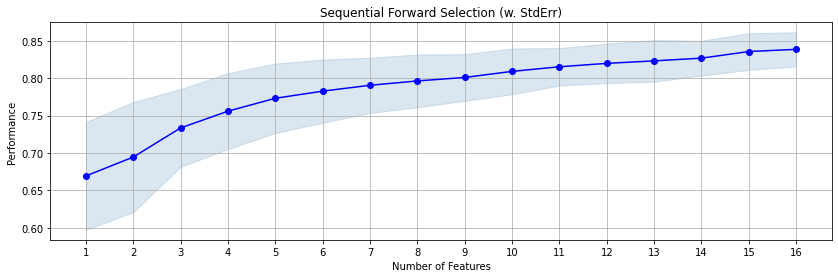

In [79]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err',figsize=(14, 4))


plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [80]:
print(f'{len(sfs1.k_feature_names_)} Features and R2 Score: {sfs1.k_score_}')

16 Features and R2 Score: 0.8384742387361983


In [81]:
predictors=list(sfs1.k_feature_names_)
predictors

['Prop_Cement_Kg',
 'Concrete_Grade_Target',
 'Supplier_Target',
 'Prop_Cement_Kg Co_Agg_Density_(ASTM_C127)_Agg2_Kg/m3',
 'Pro_Fly_Ash_Kg Prop_Silica_Fume_kg',
 'Prop_Silica_Fume_kg Prop_Admixture1_kg',
 'Prop_Silica_Fume_kg Co_Agg_Loss_Angeles_Abrasion_Value_(ASTM_C131)_Agg1_(%)',
 'Prop_Silica_Fume_kg Co_Agg_Absorption_(ASTM_C127)_Agg1_(%)',
 'Prop_Silica_Fume_kg Concrete_Grade_Target',
 'Prop_Silica_Fume_kg Supplier_Target',
 'Prop_3/4"_Agg._SSD_kg Concrete_Grade_Target',
 'Prop_Sand_SSD_kg^2',
 'Co_Agg_Aggregate_Sizes_Agg1_(in) Co_Agg_Clay_lumps_and_friable_particles_(ASTM_C142M)_Agg1_(%)',
 'Co_Agg_Aggregate_Sizes_Agg2_(in) Fine_Agg_Material_finer_than_0.075_mm_(ASTM_C117)_(%)',
 'Co_Agg_Density_(ASTM_C127)_Agg2_Kg/m3 Fine_Agg_Material_finer_than_0.075_mm_(ASTM_C117)_(%)',
 'Fine_Agg_Material_finer_than_0.075_mm_(ASTM_C117)_(%) Fine_Agg_Density_(ASTM_C128)_Kg/m3']

In [82]:
X=X[predictors]

### 6. Modelling <a class="anchor" id="six"></a>

#### 6.1 Simple Linear Regression  vs Decision Tree Example<a class="anchor" id="sixone"></a>

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=2022)

In [84]:
X_train_viz=np.array(X_train['Prop_Cement_Kg']).reshape(-1, 1)
X_test_viz=np.array(X_test['Prop_Cement_Kg']).reshape(-1, 1)

In [85]:
lr = LinearRegression()
dt = DecisionTreeRegressor()

**Fitting the Model with Train Data**

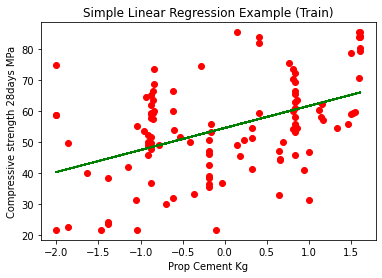

In [86]:
## Linear Regression
lr.fit(X_train_viz,y_train)

plt.scatter(X_train_viz, y_train, color = "red")
plt.plot(X_train_viz, lr.predict(X_train_viz), color = "green")
plt.title("Simple Linear Regression Example (Train)")
plt.xlabel("Prop Cement Kg")
plt.ylabel("Compressive strength 28days MPa")
plt.show()

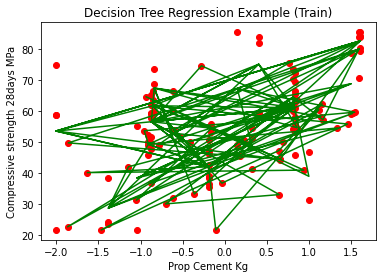

In [87]:
## Decision Tree Regression
dt.fit(X_train_viz,y_train)

plt.scatter(X_train_viz, y_train, color = "red")
plt.plot(X_train_viz, dt.predict(X_train_viz), color = "green")
plt.title("Decision Tree Regression Example (Train)")
plt.xlabel("Prop Cement Kg")
plt.ylabel("Compressive strength 28days MPa")
plt.show()

**Model Predictions with Test Data**

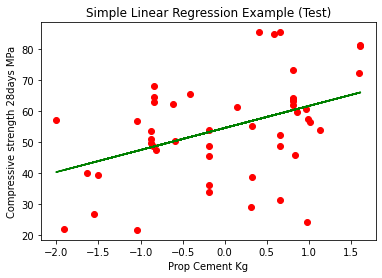

In [88]:
## Linear Regression

plt.scatter(X_test_viz, y_test, color = "red")
plt.plot(X_test_viz, lr.predict(X_test_viz), color = "green")
plt.title("Simple Linear Regression Example (Test)")
plt.xlabel("Prop Cement Kg")
plt.ylabel("Compressive strength 28days MPa")
plt.show()

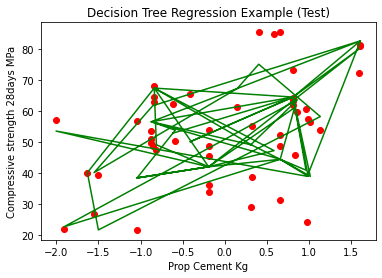

In [89]:
## Decision Tree Regression

plt.scatter(X_test_viz, y_test, color = "red")
plt.plot(X_test_viz, dt.predict(X_test_viz), color = "green")
plt.title("Decision Tree Regression Example (Test)")
plt.xlabel("Prop Cement Kg")
plt.ylabel("Compressive strength 28days MPa")
plt.show()

**Conclusion: A linear model is more appropriate due to the small sample size and risk of overfitting**

#### 6.2  Inferential Linear Regression Model  <a class="anchor" id="sixtwo"></a>

Using all data to get a sense of the predictive power of the model

In [90]:
X_full_model = sm.add_constant(X)
model = sm.OLS(y,X_full_model)
results = model.fit()
results.summary()

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     68.14
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           1.47e-58
Time:                        15:20:33   Log-Likelihood:                -497.89
No. Observations:                 160   AIC:                             1030.
Df Residuals:                     143   BIC:                             1082.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================
                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                             56.3586      0.748     75.356      0.000      54.880      57.837
Prop_Cement_Kg                                                                                     2.1993      0.587      3.745      0.000       1.038       3.360
Concrete_Grade_Target                                                                             10.6531      0.657     16.214      0.000       9.354      11.952
Supplier_Target                                                                                    1.8059      0.641      2.816      0.006       0.538       3.074
Prop_Cement_Kg Co_Agg_Density_(ASTM_C127)_Agg2_Kg/m3                                               2.4165      0.718      3.368      0.001       0.998       3.835
Pro_Fly_Ash_Kg Prop_Silica_Fume_kg                                                                -2.4400      0.830     -2.939      0.004      -4.081      -0.799
Prop_Silica_Fume_kg Prop_Admixture1_kg                                                            -4.5725      1.019     -4.487      0.000      -6.587      -2.558
Prop_Silica_Fume_kg Co_Agg_Loss_Angeles_Abrasion_Value_(ASTM_C131)_Agg1_(%)                       -3.8760      1.254     -3.090      0.002      -6.355      -1.397
Prop_Silica_Fume_kg Co_Agg_Absorption_(ASTM_C127)_Agg1_(%)                                         3.1685      1.033      3.069      0.003       1.128       5.209
Prop_Silica_Fume_kg Concrete_Grade_Target                                                          2.5474      0.639      3.984      0.000       1.283       3.811
Prop_Silica_Fume_kg Supplier_Target                                                                2.0576      0.682      3.016      0.003       0.709       3.406
Prop_3/4"_Agg._SSD_kg Concrete_Grade_Target                                                        1.0174      0.478      2.129      0.035       0.073       1.962
Prop_Sand_SSD_kg^2                                                                                -1.5821      0.360     -4.395      0.000      -2.294      -0.871
Co_Agg_Aggregate_Sizes_Agg1_(in) Co_Agg_Clay_lumps_and_friable_particles_(ASTM_C142M)_Agg1_(%)     1.6402      0.414      3.965      0.000       0.822       2.458
Co_Agg_Aggregate_Sizes_Agg2_(in) Fine_Agg_Material_finer_than_0.075_mm_(ASTM_C117)_(%)             1.1293      1.303      0.867      0.387      -1.446       3.705
Co_Agg_Density_(ASTM_C127)_Agg2_Kg/m3 Fine_Agg_Material_finer_than_0.075_mm_(ASTM_C117)_(%)       -1.4014      1.300     -1.078      0.283      -3.97

In [91]:
high_p_cols=results.pvalues[results.pvalues>0.05].index

In [92]:
print(f'''

Variables that will be dropped due to high p values are:
      
{high_p_cols.values} 
''')



Variables that will be dropped due to high p values are:
      
['Co_Agg_Aggregate_Sizes_Agg2_(in) Fine_Agg_Material_finer_than_0.075_mm_(ASTM_C117)_(%)'
 'Co_Agg_Density_(ASTM_C127)_Agg2_Kg/m3 Fine_Agg_Material_finer_than_0.075_mm_(ASTM_C117)_(%)'] 



In [93]:
X=X.drop(high_p_cols,axis=1)

In [94]:
print(f'The final number of variables used for modelling will be {len(X.columns)}')

The final number of variables used for modelling will be 14


In [95]:
X_full_model = sm.add_constant(X)
model = sm.OLS(y,X_full_model)
results = model.fit()
results.summary()

/Users/adamtassabehji/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     78.18
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           3.50e-60
Time:                        15:20:33   Log-Likelihood:                -498.59
No. Observations:                 160   AIC:                             1027.
Df Residuals:                     145   BIC:                             1073.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================================================================================================
                                                                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                             56.2029      0.695     80.900      0.000      54.830      57.576
Prop_Cement_Kg                                                                                     2.0997      0.578      3.633      0.000       0.957       3.242
Concrete_Grade_Target                                                                             10.6651      0.655     16.294      0.000       9.371      11.959
Supplier_Target                                                                                    1.9937      0.613      3.255      0.001       0.783       3.204
Prop_Cement_Kg Co_Agg_Density_(ASTM_C127)_Agg2_Kg/m3                                               2.6194      0.686      3.816      0.000       1.263       3.976
Pro_Fly_Ash_Kg Prop_Silica_Fume_kg                                                                -2.5546      0.821     -3.110      0.002      -4.178      -0.931
Prop_Silica_Fume_kg Prop_Admixture1_kg                                                            -4.7268      1.004     -4.706      0.000      -6.712      -2.742
Prop_Silica_Fume_kg Co_Agg_Loss_Angeles_Abrasion_Value_(ASTM_C131)_Agg1_(%)                       -3.7223      1.234     -3.015      0.003      -6.162      -1.282
Prop_Silica_Fume_kg Co_Agg_Absorption_(ASTM_C127)_Agg1_(%)                                         3.2528      1.026      3.169      0.002       1.224       5.282
Prop_Silica_Fume_kg Concrete_Grade_Target                                                          2.6648      0.628      4.246      0.000       1.424       3.905
Prop_Silica_Fume_kg Supplier_Target                                                                2.2532      0.657      3.428      0.001       0.954       3.552
Prop_3/4"_Agg._SSD_kg Concrete_Grade_Target                                                        1.1005      0.469      2.347      0.020       0.174       2.027
Prop_Sand_SSD_kg^2                                                                                -1.5593      0.358     -4.353      0.000      -2.267      -0.851
Co_Agg_Aggregate_Sizes_Agg1_(in) Co_Agg_Clay_lumps_and_friable_particles_(ASTM_C142M)_Agg1_(%)     1.7208      0.404      4.257      0.000       0.922       2.520
Fine_Agg_Material_finer_than_0.075_mm_(ASTM_C117)_(%) Fine_Agg_Density_(ASTM_C128)_Kg/m3          -1.8208      0.576     -3.158      0.002      -2.960      -0.681
==============================================================================
Omnibus:                        1.813   Durbin-Watson:                

#### 6.3 Model Comparison <a class="anchor" id="sixthree"></a>

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=2022)

Using the graphs below, we can see linear models performing better with the limited number of data points we have at hand.

In [97]:
regressors = {
    "XGBRegressor": XGBRegressor(),
    "LGBMRegressor": lgb.LGBMRegressor(),
    "CATBoostRegressor": cb.CatBoostRegressor(verbose=False),
    'AdaBoostRegressor':AdaBoostRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "Lasso": linear_model.Lasso(),
    "LinearRegression": LinearRegression(),
    "Ridge":Ridge(),
    "Lars": Lars(),
    "TheilSenRegressor": TheilSenRegressor(),
    "HuberRegressor": HuberRegressor(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": BayesianRidge(),
    "ElasticNet": ElasticNet(),
}

In [98]:
df_models = pd.DataFrame(columns=['model', 'run_time', 'r2_train','r2_test','r2_cv','rmse'])

for key in regressors:

    print('*',key)

    start_time = time.time()

    regressor = regressors[key]
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, 
                             X, 
                             y,
                             scoring="r2", 
                             cv=10)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'r2_train': regressor.score(X_train, y_train),
           'r2_test' : regressor.score(X_test, y_test),
           'r2_cv': np.mean(scores),
           'rmse': mean_squared_error(y_test, y_pred, squared=False)
           
    }

    df_models = df_models.append(row, ignore_index=True)

* XGBRegressor
* LGBMRegressor
* CATBoostRegressor
* AdaBoostRegressor
* RandomForestRegressor
* DecisionTreeRegressor
* Lasso
* LinearRegression
* Ridge
* Lars
* TheilSenRegressor
* HuberRegressor
* ARDRegression
* BayesianRidge
* ElasticNet


In [99]:
df_models=df_models.sort_values(by='r2_cv', ascending=False)
df_models

,model,run_time,r2_train,r2_test,r2_cv,rmse
13,BayesianRidge,0.0,0.874285,0.866338,0.730413,5.956149
8,Ridge,0.0,0.875548,0.865514,0.729839,5.974488
7,LinearRegression,0.0,0.875841,0.863319,0.727438,6.023044
9,Lars,0.0,0.875841,0.863319,0.727438,6.023044
12,ARDRegression,0.0,0.872151,0.869653,0.701722,5.881835
11,HuberRegressor,0.0,0.872585,0.845453,0.696126,6.404604
0,XGBRegressor,0.01,0.999780,0.746787,0.623936,8.197944
6,Lasso,0.0,0.814426,0.837822,0.599462,6.560818
4,RandomForestRegressor,0.05,0.969659,0.790036,0.594739,7.465083
10,TheilSenRegressor,0.22,0.828554,0.704170,0.588025,8.861004


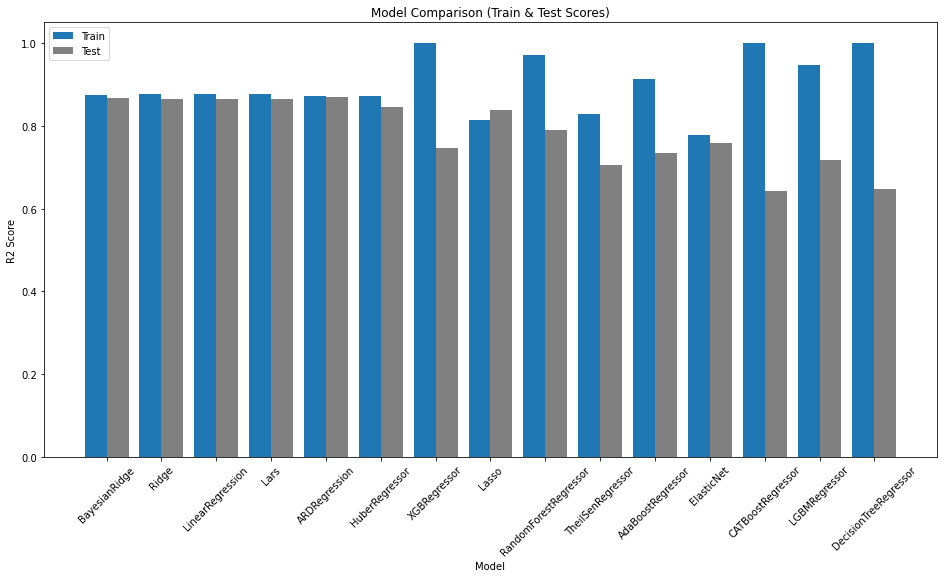

In [105]:
fig= plt.figure(figsize=(16,8))

x_axis = np.arange(len(df_models))

plt.bar(x_axis -0.2, df_models['r2_train'], width=0.4, label = 'Train')
plt.bar(x_axis +0.2, df_models['r2_test'], width=0.4, label = 'Test',color='gray')

plt.xlabel('Model')

plt.xticks(x_axis, df_models['model'],rotation=45)

plt.title('Model Comparison (Train & Test Scores)')

plt.ylabel('R2 Score')

plt.legend(['Train','Test'])

plt.show()

**Comparison of Models**

**LinearRegression (OLS)** fits a linear model with coefficients  to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

**Least-angle regression (LARS)** is a regression algorithm for high-dimensional data, At each step, it finds the feature most correlated with the target. When there are multiple features having equal correlation, instead of continuing along the same feature, it proceeds in a direction equiangular between the features

**Ridge regression** addresses some of the problems of Ordinary Least Squares (OLS) by imposing a penalty on the size of the coefficients. The ridge coefficients minimize a penalized residual sum of squares

**Bayesian regression** techniques can be used to include regularization parameters in the estimation procedure: the regularization parameter is not set in a hard sense but tuned to the data at hand. The advantages of Bayesian Regression are:It adapts to the data at hand and It can be used to include regularization parameters in the estimation procedure. Due to the Bayesian framework, the weights found are slightly different to the ones found by Ordinary Least Squares. However, Bayesian Ridge Regression is more robust to ill-posed problems.

**The Automatic Relevance Determination (as ARDRegression)** is a kind of linear model which is very similar to the Bayesian Ridge Regression, but that leads to smaller coefficients.

**The HuberRegressor** is different to Ridge because it applies a linear loss to samples that are classified as outliers. 


### 7. Hypertuning Models and Ensembling <a class="anchor" id="seven"></a>

**Hypertuning** is the process of changing the algorithms standard parameters in order to optimize performance. This can be done using GridSearchCV, which builds multiple models using different combinations and implements cross validation**

This process will be undertaken for the four best performing models (With the exception of Linear Regression and LARS that don't need tuning)

**Ridge**

In [106]:
param_grid = {
    'tol':[2,1,0.75,0.5,0.25,0.1,0.01,0.001],
    'alpha':[0.01,0.5,1,1.5,2],
    'max_iter':[10,25,50,100]
    
}


rid1 = Ridge()

rid1grid_search = GridSearchCV(estimator = rid1,param_grid = param_grid, cv = 5 ,  
                              n_jobs = -1, verbose = 2)

In [107]:
rid1grid_search.fit(X, y)
rid1grid_search.best_params_

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    8.8s finished


{'alpha': 0.01, 'max_iter': 10, 'tol': 2}

In [108]:
rid2 = Ridge()
rid2.set_params(**rid1grid_search.best_params_)

Ridge(alpha=0.01, max_iter=10, tol=2)

**Bayesian Ridge**

In [109]:
param_grid = {
    'tol':[0.1,0.01,0.001,0.0001,0.00001],
    'n_iter':[25,50,75,100,300],
    'alpha_1':[1e-04,1e-05,1e-06],
    'alpha_2':[1e-05,1e-06,1e-07],
    'lambda_1':[1e-05,1e-06,1e-07],
    'lambda_2':[1e-04,1e-05,1e-06]


}


br1 = linear_model.BayesianRidge()

br1grid_search = GridSearchCV(estimator = br1,param_grid = param_grid, cv = 5 ,  
                              n_jobs = -1, verbose = 2)

In [110]:
br1grid_search.fit(X, y)
br1grid_search.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 2025 candidates, totalling 10125 fits


[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 2072 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 4690 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 6464 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 9384 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 10125 out of 10125 | elapsed:   59.1s finished


{'alpha_1': 0.0001,
 'alpha_2': 1e-07,
 'lambda_1': 1e-07,
 'lambda_2': 0.0001,
 'n_iter': 25,
 'tol': 1e-05}

In [111]:
br2 = linear_model.BayesianRidge()
br2.set_params(**br1grid_search.best_params_)

BayesianRidge(alpha_1=0.0001, alpha_2=1e-07, lambda_1=1e-07, lambda_2=0.0001,
              n_iter=25, tol=1e-05)

**HuberRegressor**

In [112]:
param_grid = {
    'epsilon': [1.25,1.35,1.5,1.7,2,2.35],
    'max_iter':[50,100],
    'alpha':[0.1,0.01,0.001,0.0001],
    'tol':[1e-03,1e-04,1e-05]

}

h1 = HuberRegressor()

h1grid_search = GridSearchCV(estimator = h1,param_grid = param_grid, cv = 5 ,  
                              n_jobs = -1, verbose = 2)

In [113]:
h1grid_search.fit(X, y)
h1grid_search.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   13.1s finished


{'alpha': 0.0001, 'epsilon': 2.35, 'max_iter': 50, 'tol': 0.001}

In [114]:
h2 = HuberRegressor()
h2.set_params(**h1grid_search.best_params_)

HuberRegressor(epsilon=2.35, max_iter=50, tol=0.001)

**ARDRegression**

In [115]:
param_grid = {
    'n_iter':[25,50,100,300],
    'tol':[0.01,0.001,0.0001,0.00001],
    'alpha_1':[1e-05,1e-06,1e-07,1e-08],
    'lambda_1':[1e-05,1e-06,1e-07,1e-08],
    'threshold_lambda':[50,100,1000]

}


ard1 = linear_model.ARDRegression()

ard1grid_search = GridSearchCV(estimator = ard1,param_grid = param_grid, cv = 5 ,  
                              n_jobs = -1, verbose = 2)

In [116]:
ard1grid_search.fit(X, y)
ard1grid_search.best_params_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 768 candidates, totalling 3840 fits


[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1388 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 3833 out of 3840 | elapsed:   47.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3840 out of 3840 | elapsed:   47.7s finished


{'alpha_1': 1e-05,
 'lambda_1': 1e-08,
 'n_iter': 100,
 'threshold_lambda': 50,
 'tol': 1e-05}

In [117]:
ard2 = linear_model.ARDRegression()
ard2.set_params(**ard1grid_search.best_params_)

ARDRegression(alpha_1=1e-05, lambda_1=1e-08, n_iter=100, threshold_lambda=50,
              tol=1e-05)

**Hyper-Tuned Models**

In [118]:

regressors = {
    "LinearRegression": LinearRegression(),
    "Lars": Lars(),
    "Ridge":Ridge(),
    "HuberRegressor": HuberRegressor(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": linear_model.BayesianRidge(),
    "Ridge_Tuned":rid2,
    "HuberRegressor_Tuned":h2,
    "ARDRegression_Tuned": ard2,
    "BayesianRidge_Tuned": br2,
}

In [119]:
df_models = pd.DataFrame(columns=['model', 'run_time', 'r2_train','r2_test','r2_cv','rmse'])

for key in regressors:

    print('*',key)

    start_time = time.time()

    regressor = regressors[key]
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, 
                             X, 
                             y,
                             scoring="r2", 
                             cv=10)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'r2_train': regressor.score(X_train, y_train),
           'r2_test' : regressor.score(X_test, y_test),
           'r2_cv': np.mean(scores),
           'rmse': mean_squared_error(y_test, y_pred, squared=False)
           
    }

    df_models = df_models.append(row, ignore_index=True)

* LinearRegression
* Lars
* Ridge
* HuberRegressor
* ARDRegression
* BayesianRidge
* Ridge_Tuned
* HuberRegressor_Tuned
* ARDRegression_Tuned
* BayesianRidge_Tuned


**Hypertuning Results**

In [120]:
df_models=df_models.sort_values(by='r2_cv', ascending=False)
df_models

,model,run_time,r2_train,r2_test,r2_cv,rmse
5,BayesianRidge,0.0,0.874285,0.866338,0.730413,5.956149
9,BayesianRidge_Tuned,0.0,0.874285,0.866338,0.730413,5.956149
2,Ridge,0.0,0.875548,0.865514,0.729839,5.974488
6,Ridge_Tuned,0.0,0.875841,0.863350,0.727470,6.022352
0,LinearRegression,0.0,0.875841,0.863319,0.727438,6.023044
1,Lars,0.0,0.875841,0.863319,0.727438,6.023044
7,HuberRegressor_Tuned,0.0,0.875565,0.867354,0.726889,5.933477
4,ARDRegression,0.0,0.872151,0.869653,0.701722,5.881835
3,HuberRegressor,0.0,0.872585,0.845453,0.696126,6.404604
8,ARDRegression_Tuned,0.0,0.872152,0.869654,0.693494,5.881816


**Ensemble Methods**

**Stacking**: Uses several model outputs to build a final model for prediction

In [121]:
models = [('Linear Regression', LinearRegression()),
          ('LARS Regressor',Lars()),
          ('HuberRegressor_Tuned',HuberRegressor()),
          ('Ridge',Ridge()),
          ('ARDRegression_Tuned',ARDRegression()),
          ('BayesianRidge_Tuned',linear_model.BayesianRidge())]

sclf = StackingRegressor(estimators=models)

model = sclf.fit(X_train, y_train)
y_pred = model.predict(X_test)

**Voting**: Uses several model outputs and decides a final prediction based on a majority vote

In [122]:
models = [('Linear Regression', LinearRegression()),
          ('LARS Regressor',Lars()),
          ('HuberRegressor_Tuned',HuberRegressor()),
          ('Ridge',Ridge()),
          ('ARDRegression_Tuned',ARDRegression()),
          ('BayesianRidge_Tuned',linear_model.BayesianRidge())]

vclf = VotingRegressor(estimators=models)


### 8. Final Summary and Model Selection <a class="anchor" id="eight"></a>

In [123]:
regressors = {
    "LinearRegression": LinearRegression(),
    "Lars": Lars(),
    "Ridge":Ridge(),
    "HuberRegressor": HuberRegressor(),
    "ARDRegression": ARDRegression(),
    "BayesianRidge": linear_model.BayesianRidge(),
    "Ridge_Tuned":rid2,
    "HuberRegressor_Tuned":h2,
    "ARDRegression_Tuned": ard2,
    "BayesianRidge_Tuned": br2,
    'Stacking':sclf,
    'Voting':vclf
}

In [124]:
df_models = pd.DataFrame(columns=['model', 'run_time', 'r2_train','r2_test','r2_cv','rmse'])

for key in regressors:

    print('*',key)

    start_time = time.time()

    regressor = regressors[key]
    model = regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, 
                             X, 
                             y,
                             scoring="r2", 
                             cv=5)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'r2_train': regressor.score(X_train, y_train),
           'r2_test' : regressor.score(X_test, y_test),
           'r2_cv': np.mean(scores),
           'rmse': mean_squared_error(y_test, y_pred, squared=False)
           
    }

    df_models = df_models.append(row, ignore_index=True)

* LinearRegression
* Lars
* Ridge
* HuberRegressor
* ARDRegression
* BayesianRidge
* Ridge_Tuned
* HuberRegressor_Tuned
* ARDRegression_Tuned
* BayesianRidge_Tuned
* Stacking
* Voting


In [125]:
df_models=df_models.sort_values(by='r2_cv', ascending=False)
df_models

,model,run_time,r2_train,r2_test,r2_cv,rmse
10,Stacking,0.04,0.868075,0.839585,0.799503,6.525059
0,LinearRegression,0.0,0.875841,0.863319,0.796724,6.023044
1,Lars,0.0,0.875841,0.863319,0.796724,6.023044
6,Ridge_Tuned,0.0,0.875841,0.863350,0.796717,6.022352
2,Ridge,0.0,0.875548,0.865514,0.795307,5.974488
7,HuberRegressor_Tuned,0.0,0.875565,0.867354,0.795250,5.933477
9,BayesianRidge_Tuned,0.0,0.874285,0.866338,0.791282,5.956149
5,BayesianRidge,0.0,0.874285,0.866338,0.791282,5.956149
11,Voting,0.01,0.875496,0.864315,0.785820,6.001054
3,HuberRegressor,0.0,0.872585,0.845453,0.764708,6.404604


In [126]:
print(f'''

The best performing model is {df_models.iloc[0,0]} 

''')



The best performing model is Stacking 




In [127]:
for key in regressors:
    regressor = regressors[key]
    if key == df_models.iloc[0,0]:
        final_regressor= regressor
        
model = final_regressor.fit(X_train, y_train)
y_pred = model.predict(X_test)

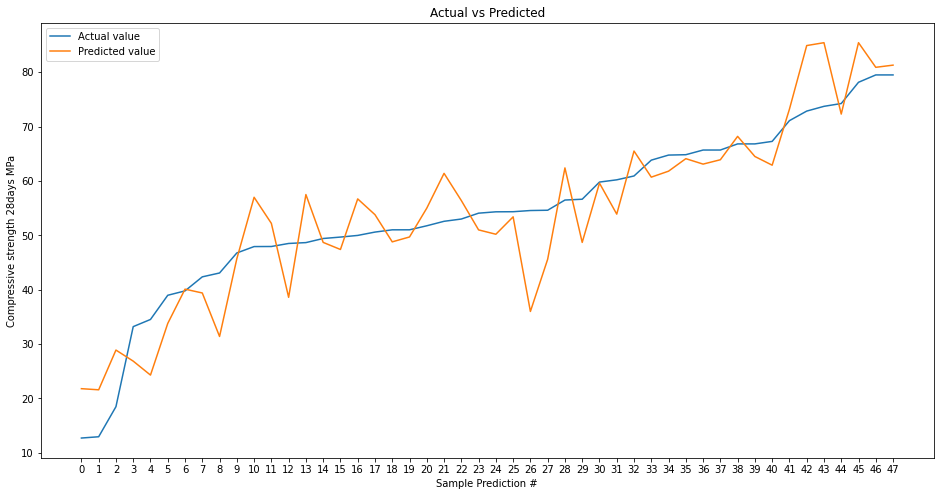

In [128]:
test = pd.DataFrame({'Predicted value':y_pred, 'Actual value':y_test})
test=test.sort_values('Predicted value').reset_index(drop=True)
fig= plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)

plt.plot(test)

plt.title("Actual vs Predicted")

plt.xticks(range(0,len(test)))

plt.xlabel("Sample Prediction #")

plt.ylabel("Compressive strength 28days MPa")

plt.legend(['Actual value','Predicted value'])

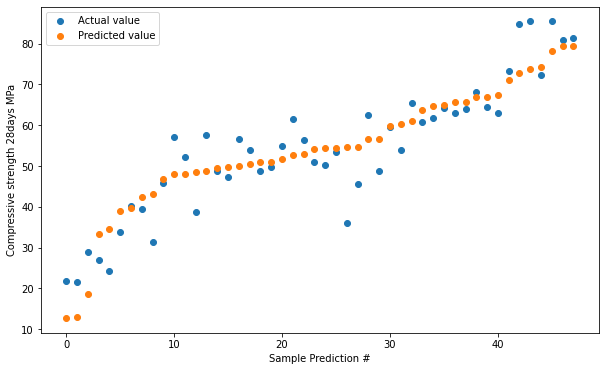

In [129]:
# Create figure
plt.figure(figsize=(10, 6))
# Create scatter plot
plt.scatter(test.index, test['Actual value'], label='Actual')

plt.scatter(test.index, test['Predicted value'], label='Predicted')

plt.xlabel("Sample Prediction #")

plt.ylabel("Compressive strength 28days MPa")

plt.legend(['Actual value','Predicted value'])

In [130]:
## Performing 100 runs as a final check using all the data

final_check_lr=pd.DataFrame(columns=['Run #', 'R2', 'RMSE'])

for run in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    run_num=run+1
    lr=LinearRegression()
    regressor = lr
    model = lr.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, 
                             X, 
                             y,
                             scoring="r2", 
                             cv=10)

    row = {'Run #': run_num,
           'R2' : regressor.score(X_test, y_test),
           'RMSE': mean_squared_error(y_test, y_pred, squared=False)}
    
    final_check_lr = final_check_lr.append(row, ignore_index=True)


In [131]:
## Performing 50 runs as a final check using all the data

final_check_final_regressor=pd.DataFrame(columns=['Run #', 'R2', 'RMSE'])

for run in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    run_num=run+1
    regressor = final_regressor
    model = final_regressor.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    scores = cross_val_score(model, 
                             X, 
                             y,
                             scoring="r2", 
                             cv=10)

    row = {'Run #': run_num,
           'R2' : regressor.score(X_test, y_test),
           'RMSE': mean_squared_error(y_test, y_pred, squared=False)}
    
    final_check_final_regressor = final_check_final_regressor.append(row, ignore_index=True)


In [132]:
print(f'''

After 100 runs:

Linear Regression R2:

Median= {round(final_check_lr['R2'].median(),3)}
Average = {round(final_check_lr['R2'].mean(),3)}


Linear Regression RMSE:

Median = {round(final_check_lr['RMSE'].median(),3)}
Average = {round(final_check_lr['RMSE'].mean(),3)} MPa


After 50 runs:

Stacking R2:

Median = {round(final_check_final_regressor['R2'].median(),3)}
Average = {round(final_check_final_regressor['R2'].mean(),3)}


Stacking RMSE:

Median = {round(final_check_final_regressor['RMSE'].median(),3)}
Average = {round(final_check_final_regressor['RMSE'].mean(),3)} MPa


''')



After 100 runs:

Linear Regression R2:

Median= 0.845
Average = 0.839


Linear Regression RMSE:

Median = 6.209
Average = 6.219 MPa


After 50 runs:

Stacking R2:

Median = 0.846
Average = 0.83


Stacking RMSE:

Median = 6.062
Average = 6.212 MPa





Text(0, 0.5, '# of runs')

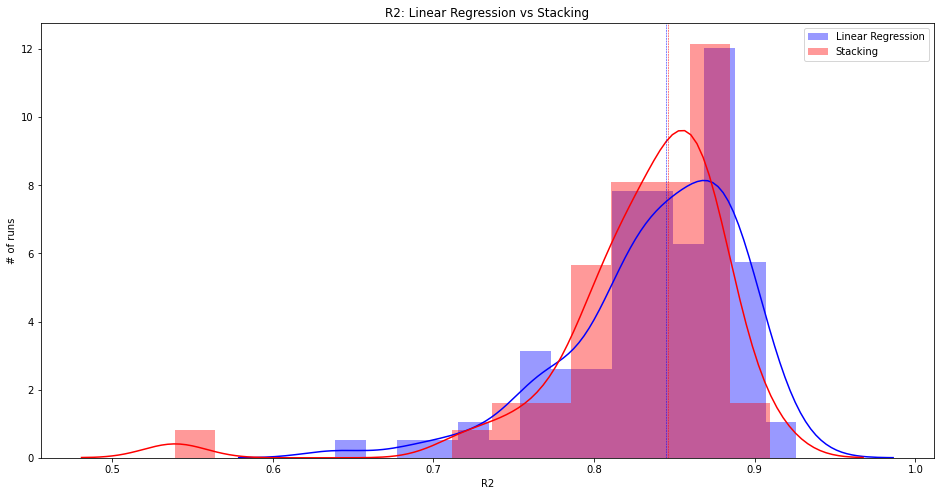

In [133]:
plt.figure(figsize=(16,8))

sns.distplot(final_check_lr["R2"],color='blue',bins=15)

sns.distplot(final_check_final_regressor["R2"],color='red',bins=15)

plt.legend(['Linear Regression','Stacking'])


plt.axvline(x=final_check_lr["R2"].median(),color='blue',ls='--', lw=0.5)

plt.axvline(x=final_check_final_regressor["R2"].median(),color='red',ls='--', lw=0.5)


plt.title('R2: Linear Regression vs Stacking')


plt.ylabel('# of runs')


Text(0, 0.5, '# of runs')

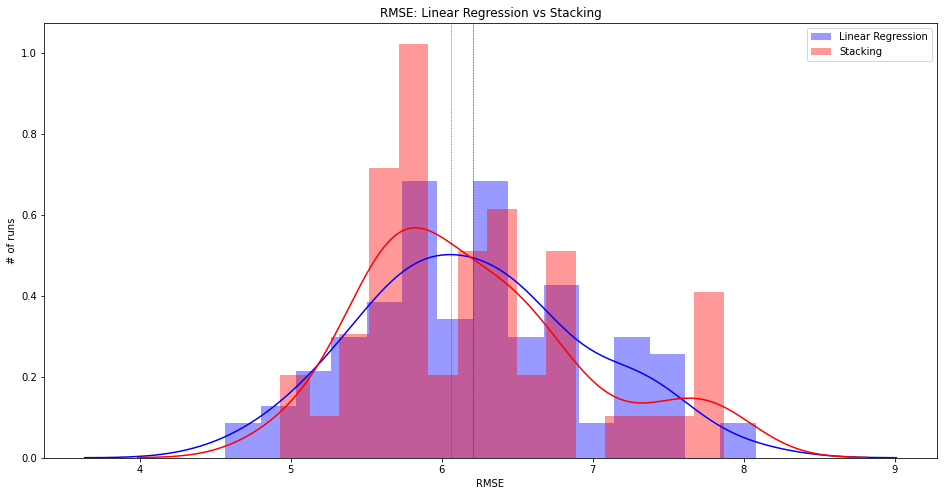

In [134]:
plt.figure(figsize=(16,8))

plt.title('RMSE: Linear Regression vs Stacking')


sns.distplot(final_check_lr["RMSE"],color='blue',bins=15)

sns.distplot(final_check_final_regressor["RMSE"],color='red',bins=15)

plt.legend(['Linear Regression','Stacking'])


plt.axvline(x=final_check_lr["RMSE"].median(),color='blue',ls='--', lw=0.5)

plt.axvline(x=final_check_final_regressor["RMSE"].median(),color='red',ls='--', lw=0.5)


plt.ylabel('# of runs')



In [135]:
#Your statements here

stop = timeit.default_timer()

print('Time: ', (stop - start)/60 ) 

beep.beep(4)

Time:  10.965828636383332


### 8. Appendix <a class="anchor" id="app"></a>

Below shows why non-linear is not appropriate for this small of a dataset, it's too sensitive to overfitting

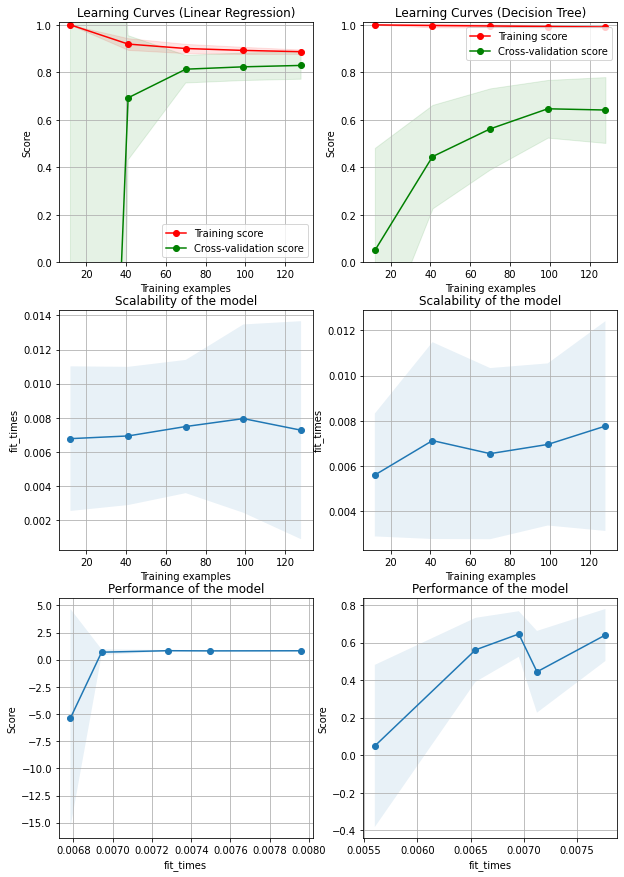

In [136]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

  
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))


title = "Learning Curves (Linear Regression)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = LinearRegression()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0, 1.01), cv=cv, n_jobs=4
)

title = "Learning Curves (Decision Tree)"
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)
estimator = DecisionTreeRegressor()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0, 1.01), cv=cv, n_jobs=4
)

plt.show()